In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from xskillscore import rmse, pearson_r, spearman_r, r2, smape, mae, me, mse
from helper_funcs import vis_map, getRMSEs

In [2]:
# Loading in Scenario Data
scenarios = ["ssp126", "ssp245", "ssp370", "ssp585"]
scenarios_data = {}

for scenario in scenarios:
    scenarios_data[scenario] = xr.open_dataset(
        f"data_preprocessed/train_val/outputs_{scenario}.nc"
    )
    
    # Convert precipitation to mm/day
    scenarios_data[scenario]["pr"] = scenarios_data[scenario]["pr"] * 86400
    scenarios_data[scenario]["pr90"] = scenarios_data[scenario]["pr90"] * 86400

In [3]:
# Loading in CNN Predictions
data_path = "model_results/"
variables = ['tas', 'dtr', 'pr', 'pr90']

# Loading in predictions
CNN_outputs = xr.merge([{v: xr.open_dataarray(data_path + "CNN/outputs_ssp245_predict_{}.nc".format(v))} for v in variables])

# Coverting precipitation to mm/day
CNN_outputs["pr"] = CNN_outputs["pr"] * 86400
CNN_outputs["pr90"] = CNN_outputs["pr90"] * 86400

# Make 'dtr' key into 'diurnal_temperature_range'
CNN_outputs = CNN_outputs.rename_vars({"dtr": "diurnal_temperature_range"})

In [4]:
# Loading in CNN Predictions
data_path = "model_results/"
variables = ['tas', 'dtr', 'pr', 'pr90']

# Loading in predictions
PINN_outputs = xr.merge([{v: xr.open_dataarray(data_path + "PINN/outputs_ssp245_predict_{}.nc".format(v))} for v in variables])

# Coverting precipitation to mm/day
PINN_outputs["pr"] = PINN_outputs["pr"] * 86400
PINN_outputs["pr90"] = PINN_outputs["pr90"] * 86400

# Make 'dtr' key into 'diurnal_temperature_range'
PINN_outputs = PINN_outputs.rename_vars({"dtr": "diurnal_temperature_range"})

In [5]:
# Loading in GP Predictions
data_path = "model_results/"
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

GP_outputs = xr.merge([{v: xr.open_dataarray(data_path + "GP/climatebench-gp-posterior-mean-{}-test-2019-2100.nc".format(v))} for v in variables])

In [6]:
# Loading in Randon Forest Predictions
data_path = "model_results/"
variables = ['tas', 'dtr', 'pr', 'pr90']

rf_predictions = xr.merge([{v: xr.open_dataarray(data_path + "Random Forest/random_forest_predicted_{}.nc".format(v))} for v in variables])

# Make 'dtr' key into 'diurnal_temperature_range'
rf_predictions = rf_predictions.rename_vars({"dtr": "diurnal_temperature_range"})

In [7]:
# Save all predictions in one dictionary
predictions = {"CNN": CNN_outputs, "GP": GP_outputs, "RF": rf_predictions, "PINN": PINN_outputs}

## Difference Between Model's Prediction and Simulation's Prediction

The graphs show the ouotput variables for the model and the simulations and their difference for the years 2020, 2050, 2100.

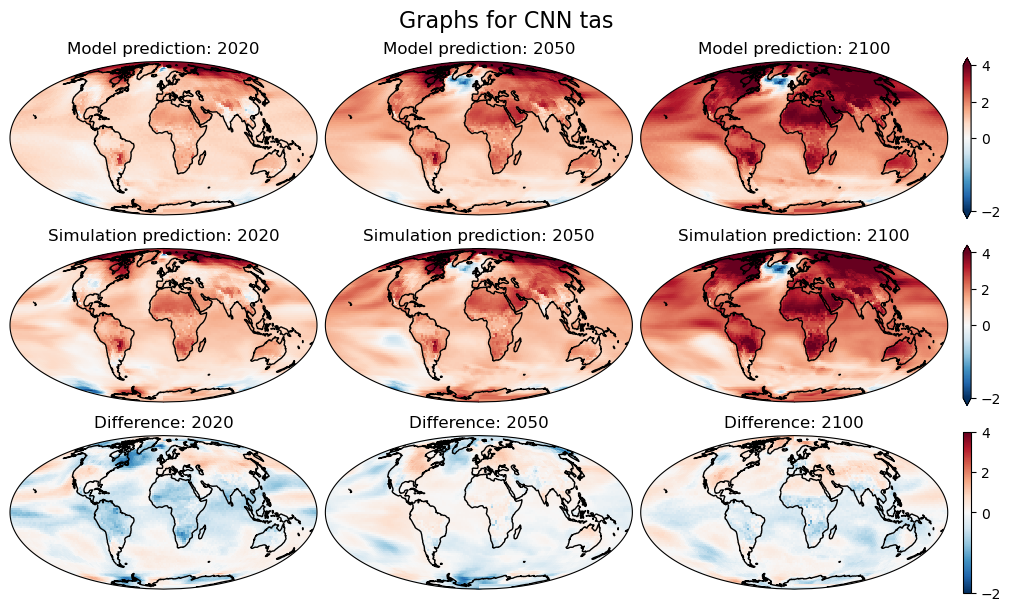

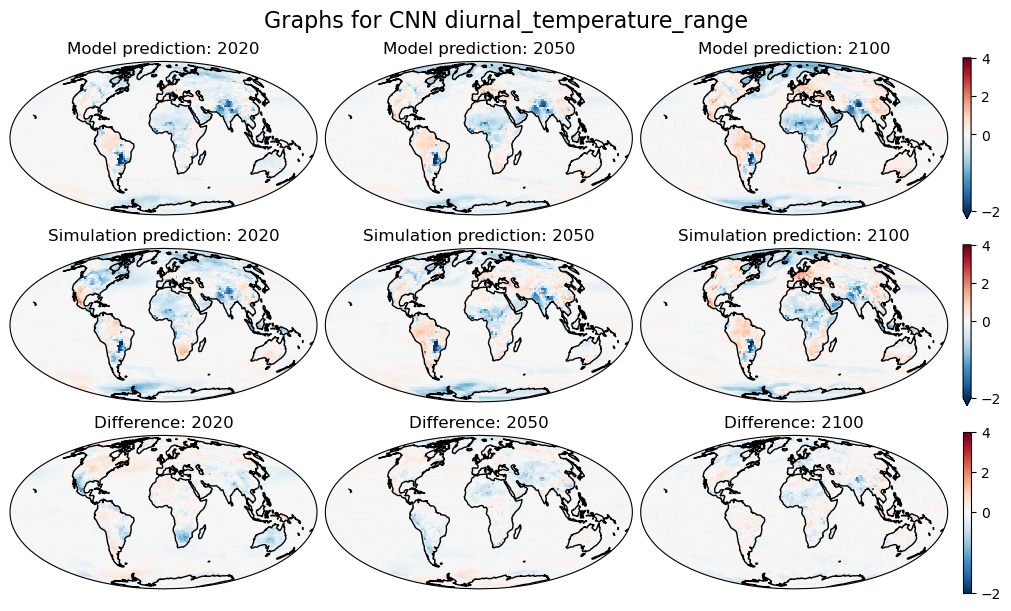

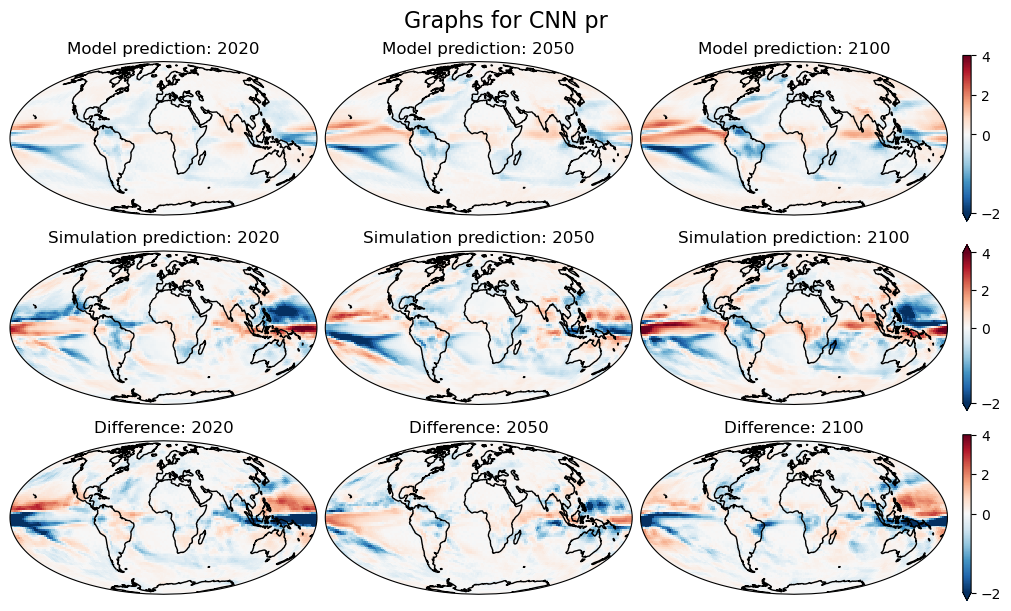

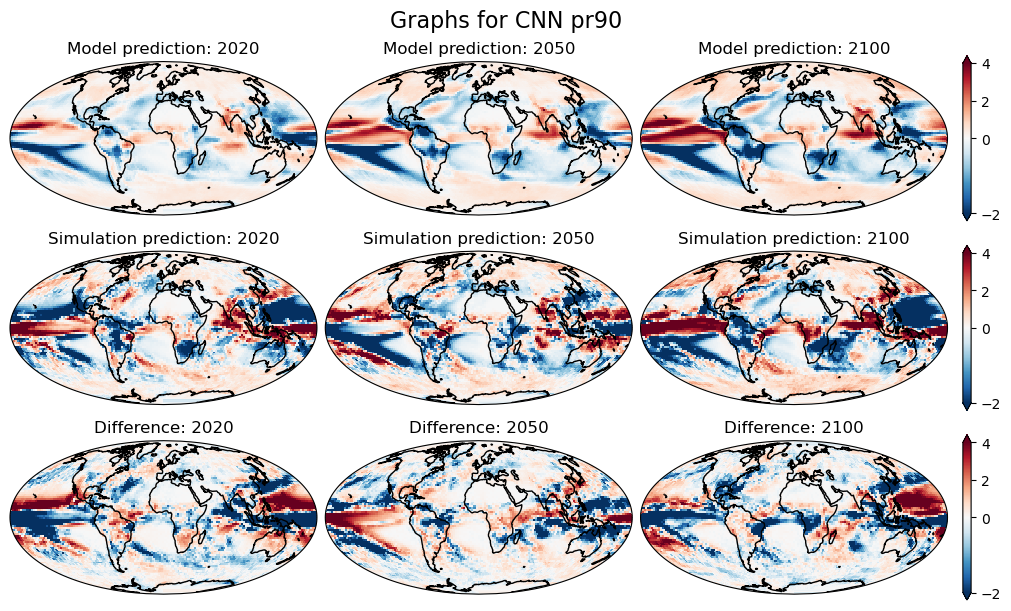

In [10]:
# Map for CNN
vis_map(scenarios_data["ssp245"], predictions["CNN"], "CNN")

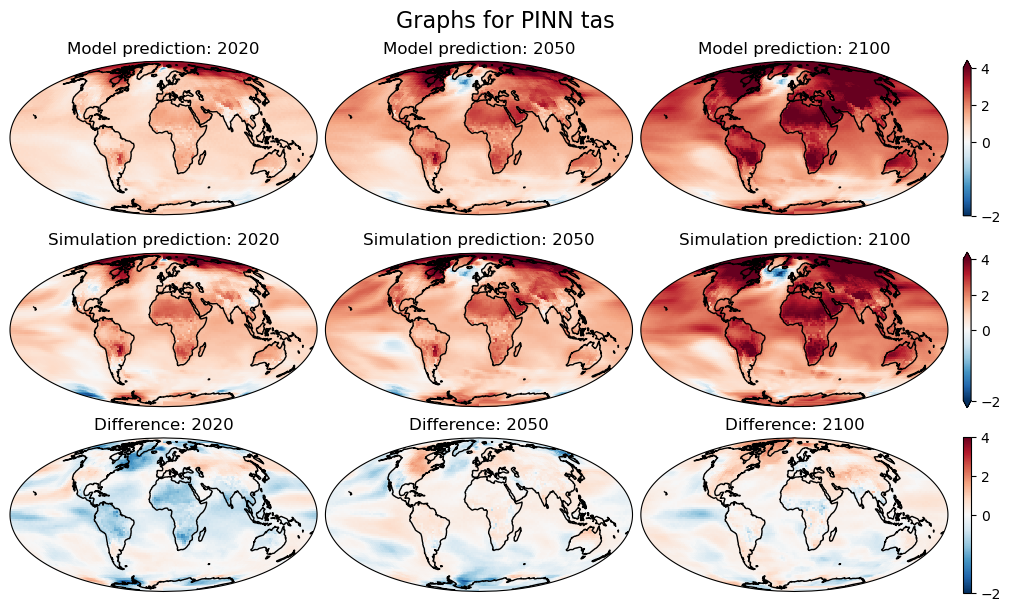

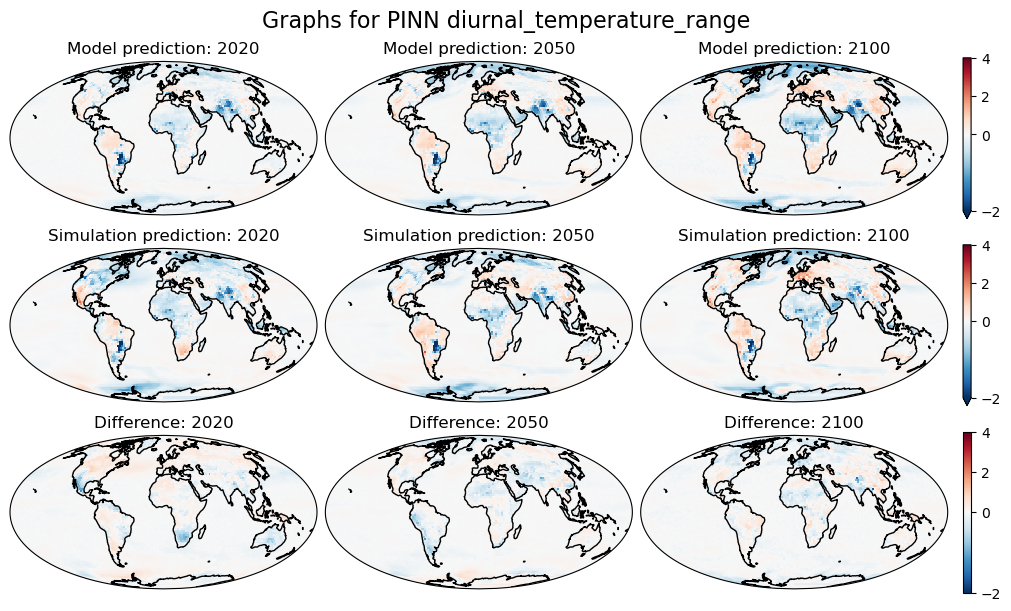

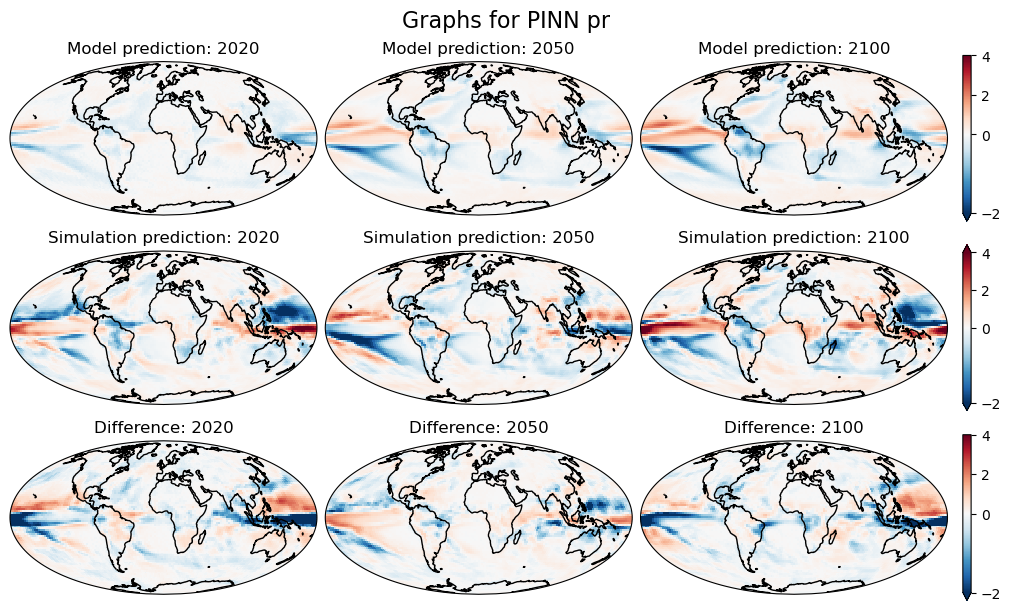

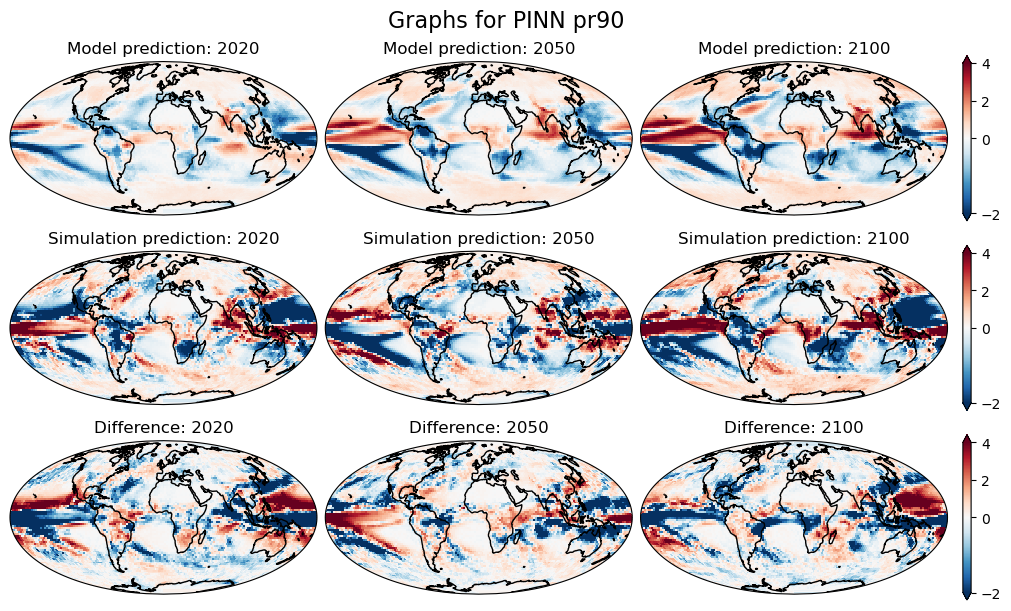

In [9]:
# Maps for PINN
vis_map(scenarios_data["ssp245"], predictions["PINN"], "PINN")

## Difference between model's prediction and simulation's prediction as a mean of the entire duration of 2020-2100

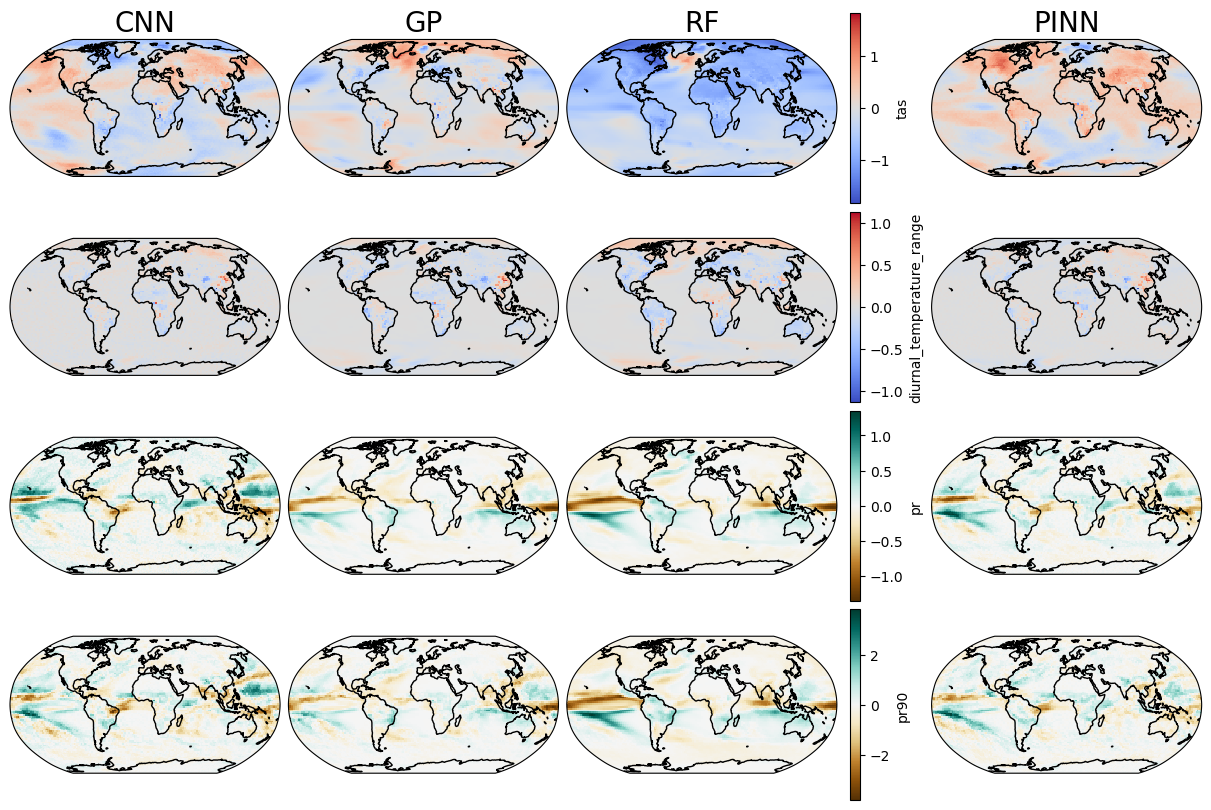

In [10]:
# Define projection
proj = ccrs.Robinson()

# Set the slice of time to get mean for (Can Change from 2015 - 2100) default will be 2020 - 2100
time_slice = slice('2020', '2100')

# Define axes
fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(12, 8), constrained_layout=True)

# Define variables, model names, labels, and kwargs for plotting
variables = ["tas", "diurnal_temperature_range", "pr", "pr90"]
model_names = ["CNN", "GP", "RF", "PINN"]
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm"), dict(cmap="coolwarm"), dict(cmap="BrBG"), dict(cmap="BrBG")]



# Get the means for each variable for each model and the difference between the model and the simulation ssp245
for i, model in enumerate(predictions.keys()):
    for j, var in enumerate(variables):
        cbar = True if i == 2 else False
        diff = predictions[model][var] - scenarios_data["ssp245"][var].mean('member')
        diff.sel(time=time_slice).mean('time').plot(ax=axes[j, i], transform=ccrs.PlateCarree(), add_colorbar=cbar, **kwargs[j])

        if j == 0:
            axes[j, i].set_title(model_names[i], fontsize=20)
        else:
            axes[j, i].set_title("")

        axes[j, i].set_global()
        axes[j, i].coastlines()

# Getting NRMSE for the models to compare with ClimateBench

In [8]:
weights = np.cos(np.deg2rad(scenarios_data['ssp245']['tas'].lat)).expand_dims(lon=144).assign_coords(lon=scenarios_data['ssp245'].lon)

In [9]:
# Using the RMSEs for CNN, GP, and RF
tables = {}
for label, preds in predictions.items():
    print(label)
    table = getRMSEs(scenarios_data['ssp245'], preds)
    print(table)
    tables[label] = table
    
tables['PINN']

CNN
              tas  diurnal_temperature_range        pr      pr90
type                                                            
Global   0.044029                   1.226369  0.177681  0.372667
Spatial  0.096646                   8.431378  2.264238  2.516356
Total    0.316791                  14.563221  3.152642  4.379692
GP
              tas  diurnal_temperature_range        pr      pr90
type                                                            
Global   0.043658                   2.649509  0.378437  0.395465
Spatial  0.090610                   9.194988  2.330103  2.604788
Total    0.308902                  22.442531  4.222290  4.582113
RF
              tas  diurnal_temperature_range         pr       pr90
type                                                              
Global   0.397886                   2.771228   0.923521   0.995583
Spatial  0.452503                  13.161018   5.599098   6.734238
Total    2.441932                  27.017157  10.216702  11.712154
PINN


tas  diurnal_temperature_range        pr      pr90
type                                                            
Global   0.042873                   0.937133  0.199880  0.315998
Spatial  0.102102                   8.331012  2.158846  2.705791
Total    0.316465                  13.016678  3.158246  4.285781

In [10]:
columns = pd.MultiIndex.from_tuples(
    [(label, metric) for label in variables for metric in ["global", "spatial", "total"]]
)
columns

MultiIndex([( 'tas',  'global'),
            ( 'tas', 'spatial'),
            ( 'tas',   'total'),
            ( 'dtr',  'global'),
            ( 'dtr', 'spatial'),
            ( 'dtr',   'total'),
            (  'pr',  'global'),
            (  'pr', 'spatial'),
            (  'pr',   'total'),
            ('pr90',  'global'),
            ('pr90', 'spatial'),
            ('pr90',   'total')],
           )

In [11]:
data_for_df = {}
types = ["Global", "Spatial", "Total"]
variables = ["tas", "diurnal_temperature_range", "pr", "pr90"]

for label, table in tables.items():
    data_for_df[label] = {}
    for v in variables:
        for t in types:
            data_for_df[label][(v, t)] = table.loc[t, v]

In [12]:
pd.DataFrame(data_for_df).T.rename(
    # rename the index to be the model name
    index={"CNN": "Convoluted Neural Network", "GP": "Gaussian Process", "RF": "Random Forest", "PINN": "Physically Informed Neural Network"},
    # rename the columns to be the variable name
    columns={"tas": "Temperature", "diurnal_temperature_range": "Diurnal Temperature Range", "pr": "Precipitation", "pr90": "Heavy Precipitation"}
)

Temperature                      \
                                        Global   Spatial     Total   
Convoluted Neural Network             0.044029  0.096646  0.316791   
Gaussian Process                      0.043658  0.090610  0.308902   
Random Forest                         0.397886  0.452503  2.441932   
Physically Informed Neural Network    0.042873  0.102102  0.316465   

                                   Diurnal Temperature Range             \
                                                      Global    Spatial   
Convoluted Neural Network                           1.226369   8.431378   
Gaussian Process                                    2.649509   9.194988   
Random Forest                                       2.771228  13.161018   
Physically Informed Neural Network                  0.937133   8.331012   

                                              Precipitation            \
                                        Total        Global   Spatial   
Convoluted Neural Network           14.563221      0.177681  2.264238   
Gaussian Process                    22.442531      0.378437  2.330103   
Random Forest                       27.017157      0.923521  5.599098   
Physically Informed Neural Network  13.016678      0.199880  2.158846   

                                              Heavy Precipitation            \
                                        Total              Global   Spatial   
Convoluted Neural Network            3.152642            0.372667  2.516356   
Gaussian Process                     4.222290            0.395465  2.604788   
Random Forest                       10.216702            0.995583  6.734238   
Physically Informed Neural Network   3.158246            0.315998  2.705791   

                                               
                                        Total  
Convoluted Neural Network            4.379692  
Gaussian Process                     4.582113  
Random Forest                       11.712154  
Physically Informed Neural Network   4.285781